In [1]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/bin/bash: line 1: /usr/bin/rm: Argument list too long
/kaggle/working


In [2]:
import os
import sys

PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [3]:
import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base_torch

MODEL_NAME = "cnn"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger(f"{ CFG[MODEL_NAME]['execution']['exp_id']}.log")
logger = get_logger("main")
seed_base_torch(CFG[MODEL_NAME]["execution"]["seed"])

2024-11-23 13:19:46.003717: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 13:19:46.031100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


exp_024


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
set seed: 46


In [4]:
import warnings

import numpy as np
import polars as pl
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [5]:
train = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "train_features.csv"))
train = (
    train.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(
        pl.col("offset").cast(pl.Float32),
        pl.lit(False).alias("submit"),
    )
)
test = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "test_features.csv"))
test = (
    test.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(
        pl.col("offset").cast(pl.Float32),
        pl.lit(True).alias("submit"),
    )
)
train = pl.concat([train, test], how="diagonal")
print(train.shape)
train.head(1)

(45098, 33)


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,sceneID,offset,submit
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f32,bool
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320.0,false


In [6]:
# normalize
train = train.with_columns(
    pl.col("vEgo") / 30,
    pl.col("aEgo"),
    pl.col("steeringAngleDeg") / 400,
    pl.col("steeringTorque") / 600,
    pl.col("offset") / pl.col("offset").max(),
)

In [7]:
from penguinml.utils.contena import FeatureContena

from feature_engineering import add_basic_features, add_scene_lag_features

features = FeatureContena()
train, features = add_basic_features(train, features)
train, features = add_scene_lag_features(train, features)
print(len(features.num_features()))
train[features.num_features()].describe()

25


statistic,aEgo,aEgo_diff_-1,aEgo_diff_1,aEgo_shift_-1,aEgo_shift_1,gas,gas_diff_-1,gas_diff_1,gas_shift_-1,gas_shift_1,steeringAngleDeg,steeringAngleDeg_diff_-1,steeringAngleDeg_diff_1,steeringAngleDeg_shift_-1,steeringAngleDeg_shift_1,steeringTorque,steeringTorque_diff_-1,steeringTorque_diff_1,steeringTorque_shift_-1,steeringTorque_shift_1,vEgo,vEgo_diff_-1,vEgo_diff_1,vEgo_shift_-1,vEgo_shift_1
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",45098.0,35577.0,35577.0,35577.0,35577.0,45098.0,35577.0,35577.0,35577.0,35577.0,45098.0,35577.0,35577.0,35577.0,35577.0,45098.0,35577.0,35577.0,35577.0,35577.0,45098.0,35577.0,35577.0,35577.0,35577.0
"""null_count""",0.0,9521.0,9521.0,9521.0,9521.0,0.0,9521.0,9521.0,9521.0,9521.0,0.0,9521.0,9521.0,9521.0,9521.0,0.0,9521.0,9521.0,9521.0,9521.0,0.0,9521.0,9521.0,9521.0,9521.0
"""mean""",-0.016168,-0.005095,0.005095,-0.005095,0.005095,0.083971,-0.000771,0.000771,-0.000771,0.000771,-0.005274,0.000025,-0.000025,0.000025,-0.000025,-0.031763,-0.000984,0.000984,-0.000984,0.000984,0.306156,0.001376,-0.001376,0.001376,-0.001376
"""std""",0.631639,0.860365,0.860365,0.860365,0.860365,0.109826,0.126945,0.126945,0.126945,0.126945,0.163457,0.186424,0.186424,0.186424,0.186424,0.184867,0.249753,0.249753,0.249753,0.249753,0.240915,0.086836,0.086836,0.086836,0.086836
"""min""",-4.936206,-5.84588,-5.796605,-5.84588,-5.796605,0.0,-0.8,-0.66,-0.8,-0.66,-1.203486,-1.962355,-2.337468,-1.962355,-2.337468,-1.166667,-1.481667,-1.371667,-1.481667,-1.371667,-0.005569,-0.604864,-0.57511,-0.604864,-0.57511
"""25%""",-0.237048,-0.323888,-0.368738,-0.323888,-0.368738,0.0,-0.04,-0.05,-0.04,-0.05,-0.008665,-0.008017,-0.007615,-0.008017,-0.007615,-0.156667,-0.146667,-0.143333,-0.146667,-0.143333,0.086478,-0.033128,-0.031659,-0.033128,-0.031659
"""50%""",-2.1050e-15,-8.0168e-37,8.0168e-37,-8.0168e-37,8.0168e-37,0.0,0.0,0.0,0.0,0.0,-0.0009,0.0,0.0,0.0,0.0,-0.021667,0.0,0.0,0.0,0.0,0.284483,-1.5867e-13,1.5867e-13,-1.5867e-13,1.5867e-13
"""75%""",0.222053,0.368738,0.323888,0.368738,0.323888,0.165,0.05,0.04,0.05,0.04,0.00653,0.007615,0.008017,0.007615,0.008017,0.085,0.143333,0.146667,0.143333,0.146667,0.47714,0.031659,0.033128,0.031659,0.033128
"""max""",3.14007,5.796605,5.84588,5.796605,5.84588,0.915,0.66,0.8,0.66,0.8,1.211729,2.337468,1.962355,2.337468,1.962355,1.166667,1.371667,1.481667,1.371667,1.481667,0.918375,0.57511,0.604864,0.57511,0.604864


In [8]:
# fillna
for col in features.num_features():
    train = train.with_columns(pl.col(col).fill_null(-1))

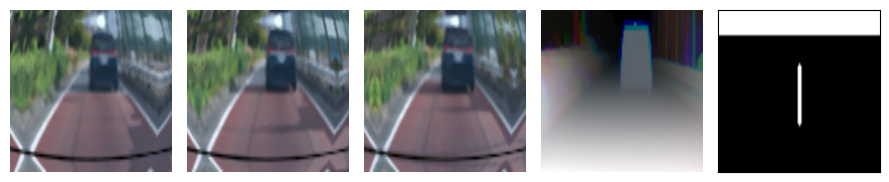

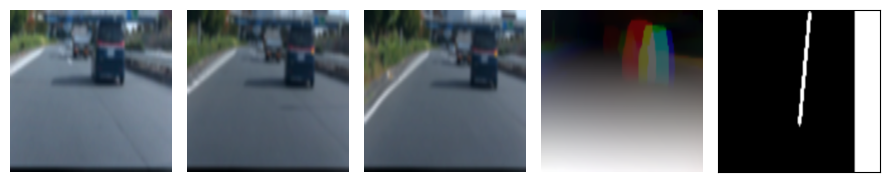

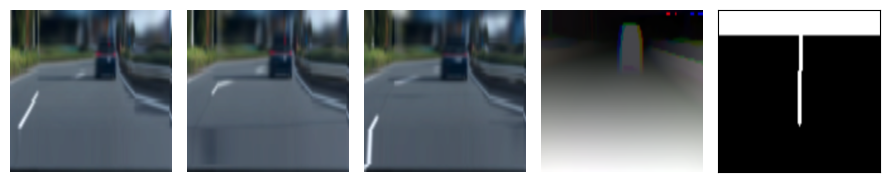

In [9]:
import os
import random
import sys
from typing import Dict

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import polars as pl
from PIL import Image
from torch.utils.data import Dataset

from const import TARGET_COLS

IMAGE_CACHE = {}

AUG_PROB = 0.5
IMG_SIZE = 256

train_aug = [
    A.RandomBrightnessContrast(
        brightness_limit=0.3,
        contrast_limit=0.3,
        p=0.5,
    ),
    A.OneOf(
        [
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ],
        p=AUG_PROB,
    ),
    A.OneOf(
        [
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.0),
            A.ElasticTransform(alpha=3),
        ],
        p=AUG_PROB,
    ),
    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE, IMG_SIZE),
    # A.CoarseDropout(
    #     max_holes=16,
    #     max_height=64,
    #     max_width=64,
    #     min_holes=1,
    #     min_height=4,
    #     min_width=4,
    #     p=AUG_PROB,
    # ),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]
valid_aug = [
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]


def load_image(ID: str) -> np.ndarray:
    # if ID not in IMAGE_CACHE:
    image = np.concatenate(
        [
            cv2.cvtColor(
                cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t.png")),
                cv2.COLOR_BGR2RGB,
            ),
            cv2.cvtColor(
                cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t-0.5.png")),
                cv2.COLOR_BGR2RGB,
            ),
            cv2.cvtColor(
                cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t-1.0.png")),
                cv2.COLOR_BGR2RGB,
            ),
        ],
        axis=2,
    )  # (H, W, C)

    feat_image = np.concatenate(
        [
            cv2.imread(f"/kaggle/input/depth_image/depth/{ID}/1-3.png"),
            np.load("/kaggle/input/table_image/image/" + ID + ".npy").reshape(64, 128, 1),
        ],
        axis=2,
    )
    # IMAGE_CACHE[ID] = image
    # return IMAGE_CACHE[ID]
    return image, feat_image


class Atma18ImageDataset(Dataset):
    def __init__(
        self,
        df: pl.DataFrame,
        aug,
    ):
        self.df = df
        self.meta_features = df[features.num_features()].to_numpy().astype(np.float32)
        self.targets = df[TARGET_COLS].to_numpy().astype(np.float32)
        self.aug = A.Compose(aug)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        ID = self.df["ID"][index]

        image, feat_image = load_image(ID)
        image = np.concatenate(
            [
                self.aug(image=image)["image"],
                A.Compose(valid_aug)(image=feat_image)["image"],
            ],
            axis=2,
        )
        image = image.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)
        image = image.astype(np.float32)

        meta = self.meta_features[index]
        targets = self.targets[index]

        return {"image": image, "meta": meta}, targets


# check
for i in range(3):
    dataset = Atma18ImageDataset(train, aug=train_aug)
    x, targets = dataset[i]
    image = x["image"]

    fig, axs = plt.subplots(1, 5, figsize=(9, 4))
    for j, ax in enumerate(axs):
        img = image[j * 3 : j * 3 + 3].transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        if img.shape[2] == 1:
            ax.imshow(img[:, :, 0], cmap="gray")
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else:
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()


# # caching
# for i in tqdm(range(len(train))):
#     dataset[i]

In [10]:
import timm
import torch
from torch import nn


class Atma18CnnModel(nn.Module):
    def __init__(
        self,
        meta_dim: int,
        model_name="resnet18d",
        pretrained: bool = True,
        in_chans: int = 3,
        hidden_dim: int = 2048,
        output_dim: int = 1,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.backbone = timm.create_model(
            model_name=model_name,
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=0,
        )
        self.in_features = self.backbone.num_features

        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_dim, hidden_dim),
        )

        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.in_features + hidden_dim, output_dim),
        )

    def forward(self, x) -> torch.Tensor:
        image, meta = x["image"], x["meta"]
        image = self.backbone(image)
        meta = self.meta_mlp(meta)
        x = torch.cat([image, meta], dim=1)
        x = self.head(x)
        return x

## CV Split


In [11]:
train_folds = pl.read_csv(CFG["dataset"]["train_fold_path"])
train = train.join(train_folds, on="sceneID", how="left")
# assert train["fold"].null_count() == 0

## Training


In [12]:
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output, display
from penguinml.nn.utils.dataloader import get_dataloaders
from penguinml.nn.utils.trainer import Trainer
from torchmetrics import MeanAbsoluteError, MetricCollection
from transformers import get_cosine_schedule_with_warmup

In [13]:
seeds = [0, 1]
backbones = ["tf_efficientnet_b0_ns", "tf_efficientnet_b1_ns", "tf_efficientnet_b2_ns", "resnet18d"]

all_scores = []

for seed in seeds:
    for backbone in backbones:
        # cv split
        all_scenes = train.filter(~pl.col("submit"))["sceneID"].unique().to_numpy()
        np.random.seed(seed)
        np.random.shuffle(all_scenes)
        scene2fold = {}
        for i, scene in enumerate(all_scenes):
            scene2fold[scene] = i % 5
        fold_df = pl.DataFrame({"sceneID": all_scenes, "fold": [scene2fold[s] for s in all_scenes]})
        train = train.drop("fold").join(fold_df, how="left", on="sceneID")
        # assert train["fold"].null_count() == 0

        this_score = {
            "seed": seed,
            "backbone": backbone,
        }

        oof_dfs = []
        sub_preds = []
        for fold in range(5):
            train_df = train.filter(pl.col("fold") != fold).filter(~pl.col("submit"))
            valid_df = train.filter(pl.col("fold") == fold).filter(~pl.col("submit"))
            test_df = train.filter(pl.col("submit")).sort("ID")

            train_dataset = Atma18ImageDataset(train_df, train_aug)
            valid_dataset = Atma18ImageDataset(valid_df, valid_aug)
            test_dataset = Atma18ImageDataset(test_df, valid_aug)

            bs = 128

            train_dataloader, valid_dataloader = get_dataloaders(
                train_dataset,
                valid_dataset,
                batch_size=bs,
                num_workers=16,
                pin_memory=False,
                seed=seed,
            )
            _, test_dataloader = get_dataloaders(
                test_dataset,
                test_dataset,
                batch_size=bs,
                num_workers=16,
                pin_memory=False,
                seed=seed,
            )

            device = "cuda"
            model = model = Atma18CnnModel(
                meta_dim=len(features.num_features()),
                model_name=backbone,
                pretrained=True,
                in_chans=13,
                hidden_dim=2048,
                output_dim=len(TARGET_COLS),
            ).to(device)

            max_epoch = CFG[MODEL_NAME]["trainer"]["max_epoch"]
            loss_fn = nn.L1Loss()
            optimizer = optim.AdamW(model.parameters(), **CFG[MODEL_NAME]["optimizer"])
            num_training_steps = len(train_dataloader) * max_epoch
            scheduler = get_cosine_schedule_with_warmup(optimizer, 300, num_training_steps)
            scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
            metrics = MetricCollection([MeanAbsoluteError()])

            trainer = Trainer(
                model=model,
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                metrics=metrics,
                save_path=f"best_model_fold{fold}.pth",
                **CFG[MODEL_NAME]["trainer"],
            )

            # train
            trainer.train()

            # val
            oof = trainer.inference()
            gt = valid_df[TARGET_COLS].to_numpy()
            valid_df = valid_df.with_columns(*[pl.Series(TARGET_COLS[i], oof[:, i]) for i in range(len(TARGET_COLS))])
            oof_dfs.append(valid_df.select(["ID"] + TARGET_COLS))

            mae = np.mean(np.abs(oof - gt))

            # test
            trainer.valid_dataloader = test_dataloader
            sub = trainer.inference()
            sub_preds.append(sub)

            del model, trainer
            gc.collect()
            torch.cuda.empty_cache()

            this_score[f"fold{fold}"] = mae

            clear_output()
            display(pl.DataFrame(all_scores + [this_score]))

        oof_df = pl.concat(oof_dfs).sort("ID")
        train = train.sort("ID")

        mae = np.mean(np.abs(oof_df[TARGET_COLS].to_numpy() - train.filter(~pl.col("submit"))[TARGET_COLS].to_numpy()))
        print(f"MAE: {mae}")
        this_score["CV"] = mae
        all_scores.append(this_score)
        clear_output()
        display(pl.DataFrame(all_scores))

        oof_df.write_csv(
            os.path.join(
                CFG["output_dir"],
                f"{backbone}_seed_{seed}_oof.csv",
            )
        )
        sub_preds = np.stack(sub_preds).mean(axis=0)  # medがいいかも
        sub_df = test_df.with_columns(
            *[pl.Series(TARGET_COLS[i], sub_preds[:, i]) for i in range(len(TARGET_COLS))]
        ).sort("ID")
        sub_df.write_csv(
            os.path.join(
                CFG["output_dir"],
                f"{backbone}_seed_{seed}_submission.csv",
            )
        )

seed,backbone,fold0,fold1,fold2,fold3,fold4,CV
i64,str,f64,f64,f64,f64,f64,f64
0,"""tf_efficientnet_b0_ns""",0.197919,0.198617,0.194706,0.194276,0.197288,0.196558
0,"""tf_efficientnet_b1_ns""",0.195503,0.197983,0.196374,0.193538,0.192995,0.195271
0,"""tf_efficientnet_b2_ns""",0.201063,0.19728,0.194164,0.196298,0.196139,0.196974
0,"""resnet18d""",0.19932,0.193763,0.197375,0.194478,0.203558,0.197676
1,"""tf_efficientnet_b0_ns""",0.198071,0.192792,0.198166,0.196162,0.197666,0.196562
1,"""tf_efficientnet_b1_ns""",0.192508,0.196021,0.193241,0.196841,0.19858,0.195434
1,"""tf_efficientnet_b2_ns""",0.199134,0.195107,0.195753,0.198129,0.195282,0.196676
1,"""resnet18d""",0.199947,0.193367,0.197692,0.197635,0.198507,0.197419


In [14]:
from glob import glob

files = glob(os.path.join(CFG["output_dir"], "*oof.csv"))
oof_df = pl.read_csv(files[0]).sort("ID")
for c in TARGET_COLS:
    oof_df = oof_df.with_columns(pl.lit(0).alias(c))
for f in files:
    df = pl.read_csv(f).sort("ID")
    for c in TARGET_COLS:
        oof_df = oof_df.with_columns(oof_df[c] + df[c] / len(files))

oof_df.write_csv(os.path.join(CFG["output_dir"], "oof.csv"))
train = train.sort("ID")
mae = np.mean(np.abs(oof_df[TARGET_COLS].to_numpy() - train.filter(~pl.col("submit"))[TARGET_COLS].to_numpy()))
mae

0.18929189009137154

In [15]:
files = glob(os.path.join(CFG["output_dir"], "*submission.csv"))
oof_df = pl.read_csv(files[0]).sort("ID")
for c in TARGET_COLS:
    oof_df = oof_df.with_columns(pl.lit(0).alias(c))
for f in files:
    df = pl.read_csv(f).sort("ID")
    for c in TARGET_COLS:
        oof_df = oof_df.with_columns(oof_df[c] + df[c] / len(files))

oof_df.write_csv(os.path.join(CFG["output_dir"], "submission.csv"))